In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image  # Or use cv2 if preferred
from tqdm import tqdm

# Check for CUDA availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
class WaferDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Assumes subfolders are classes
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Load as grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        
        # Enhanced feature extraction
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
# Data directories (CHANGE THESE TO YOUR ACTUAL PATHS!)
train_dir = r"augmented_dataset_with_resize\train"
test_dir = r"augmented_dataset_with_resize\test"

# Image transformations
image_size = 128 #Standard image size
train_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)), #All images must be the same size.
    transforms.RandomRotation(degrees=20),  # Rotate image
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images.
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)), #All images must be the same size.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images.
])

# Create datasets
train_dataset = WaferDataset(root_dir=train_dir, transform=train_transforms)
test_dataset = WaferDataset(root_dir=test_dir, transform=test_transforms)

# Create DataLoaders
batch_size = 32 #Adjust
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Number of classes
num_classes = len(train_dataset.classes) #get number of classes from Dataset.

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

Number of training examples: 13500
Number of testing examples: 4500
Number of classes: 9
Classes: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


In [6]:
model = ImprovedCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Checkpoint loading
# checkpoint_dir = ""  # Create a directory to store checkpoints
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

num_epochs = 100 #Adjust
start_epoch = 0  # Initialize starting epoch

# Check for existing checkpoint
checkpoint_path = "model_checkpoint1.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    print(f"Resuming training from epoch {start_epoch}")

In [ ]:
for epoch in range(start_epoch, num_epochs):  # Iterate through remaining epochs
    running_loss = 0.0
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Save checkpoint every few epochs (or every epoch)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'classes': train_dataset.classes,  # Save class labels
        # Add other relevant information here (e.g., loss history)
    }, checkpoint_path) #Saves a specific dictionary with your data

print("Finished Training")

In [12]:
model.load_state_dict(torch.load('model_checkpoint1.pth', map_location=device)['model_state_dict'])

model.eval()
# Initialize lists to store predictions and labels
y_true = []
y_pred = []

# Evaluate model
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        y_true.extend(labels.cpu().numpy())   # Store true labels
        y_pred.extend(predicted.cpu().numpy())  # Store predictions

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

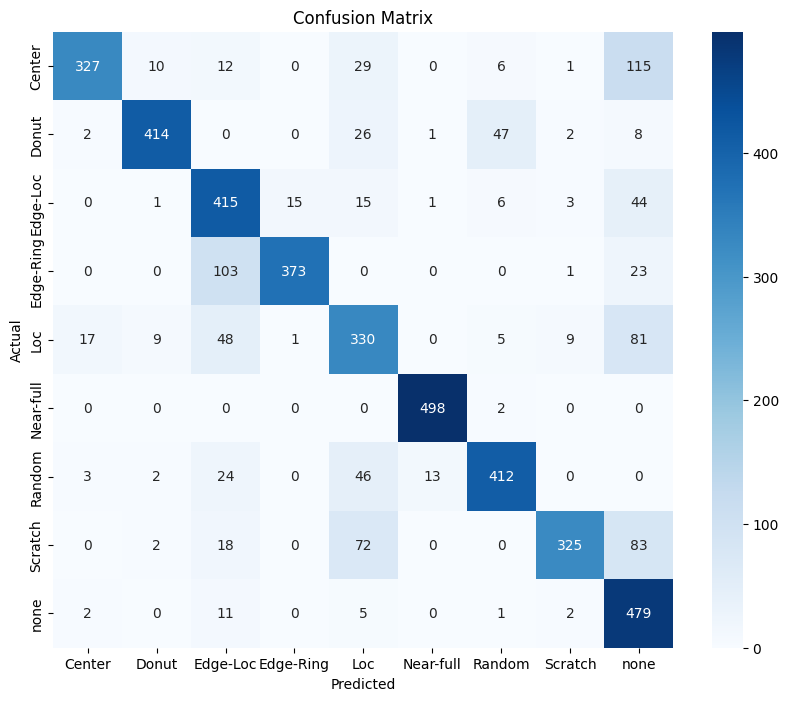

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


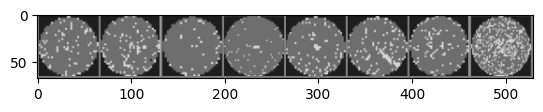

GroundTruth:  normal normal normal Center normal Loc normal Random
Predicted:  normal Loc Loc Center Center Loc Loc Random


In [78]:
def imshow(img):
    """Display an image"""
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
num_to_show = min(8, images.size(0))
indices = torch.randperm(images.size(0))[:num_to_show]

# Move selected images and labels to device
images = images[indices].to(device)
labels = labels[indices].to(device)


# Show images
imshow(torchvision.utils.make_grid(images.cpu()))#Moved back to the CPU before plotting

# Print labels (getting String values now from the dataset)
print('GroundTruth: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(8))) #Getting String labels

# Make predictions and print them
outputs = model(images)
_, predicted = torch.max(outputs, 1)

def displayLabel(predicted):
    """Display predicted labels (with actual String value)"""
    return [train_dataset.classes[pred_value.item()] for pred_value in predicted] #Getting String Labels

print('Predicted: ', ' '.join(displayLabel(predicted)))

In [75]:
# prompt: i have given the path of single image i want prediction

import torch
import torchvision.transforms as transforms
from PIL import Image

# Assuming 'model' and 'device' are defined as in your previous code
# ... (your model definition and training code)

def predict_single_image(image_path, model, device, transform):
    """Predicts the class of a single image."""
    model.eval()  # Set the model to evaluation mode
    try:
        image = Image.open(image_path).convert('L')
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
        # Assuming train_dataset is available
        predicted_class = train_dataset.classes[predicted.item()]
        return predicted_class
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
image_path = "/content/701.png"  # Replace with the actual path
image_size = 64  #Make sure image size is same

test_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)), #All images must be the same size.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images.
])
prediction = predict_single_image(image_path, model, device, test_transforms)

if prediction:
    print(f"Prediction for {image_path}: {prediction}")


Prediction for /content/701.png: normal
